In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
df = pd.read_csv('/kaggle/input/scene-classification/train-scene classification/train.csv')

In [3]:
# Root directory for dataset
dataroot = "data/celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [4]:
import random
import torch

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
mountains = df[df.label==2]
mountains['image_path']="/kaggle/input/scene-classification/train-scene classification/train/" + mountains.image_name

mountains.head()

/tmp/ipykernel_19/1109277979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mountains['image_path']="/kaggle/input/scene-classification/train-scene classification/train/" + mountains.image_name


,image_name,label,image_path
7,10.jpg,2,/kaggle/input/scene-classification/train-scene...
9,13.jpg,2,/kaggle/input/scene-classification/train-scene...
10,15.jpg,2,/kaggle/input/scene-classification/train-scene...
13,18.jpg,2,/kaggle/input/scene-classification/train-scene...
18,24.jpg,2,/kaggle/input/scene-classification/train-scene...


In [7]:



manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)

In [8]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms


class SceneDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform if transform else transforms.ToTensor()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path and label from the dataframe
        img_path = self.df.loc[idx, 'image_path']
        label = int(self.df.loc[idx, 'label'])

        # Load and transform image
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        return image


In [9]:
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),  # Converts to [0, 1]
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize to [-1, 1] if using Tanh in GAN
])


In [10]:
from torch.utils.data import DataLoader


# df_mountain is your filtered DataFrame for class "mountains"
dataset = SceneDataset(mountains, transform=transform)

# Use DataLoader to batch and shuffle
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)


In [11]:
# Function to display a batch of images
import matplotlib.pyplot as plt
def show_images(images, ncols=8):
    """Display a grid of images"""
    n_images = images.size(0)
    nrows = (n_images // ncols) + (n_images % ncols > 0)  # calculate rows needed
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3))
    axes = axes.flatten()
    
    for i in range(n_images):
        img = images[i].permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        img = img * 0.5 + 0.5  # De-normalize the image to range [0, 1]
        axes[i].imshow(img)
        axes[i].axis('off')  # Turn off axis for a cleaner view
    
    for i in range(n_images, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

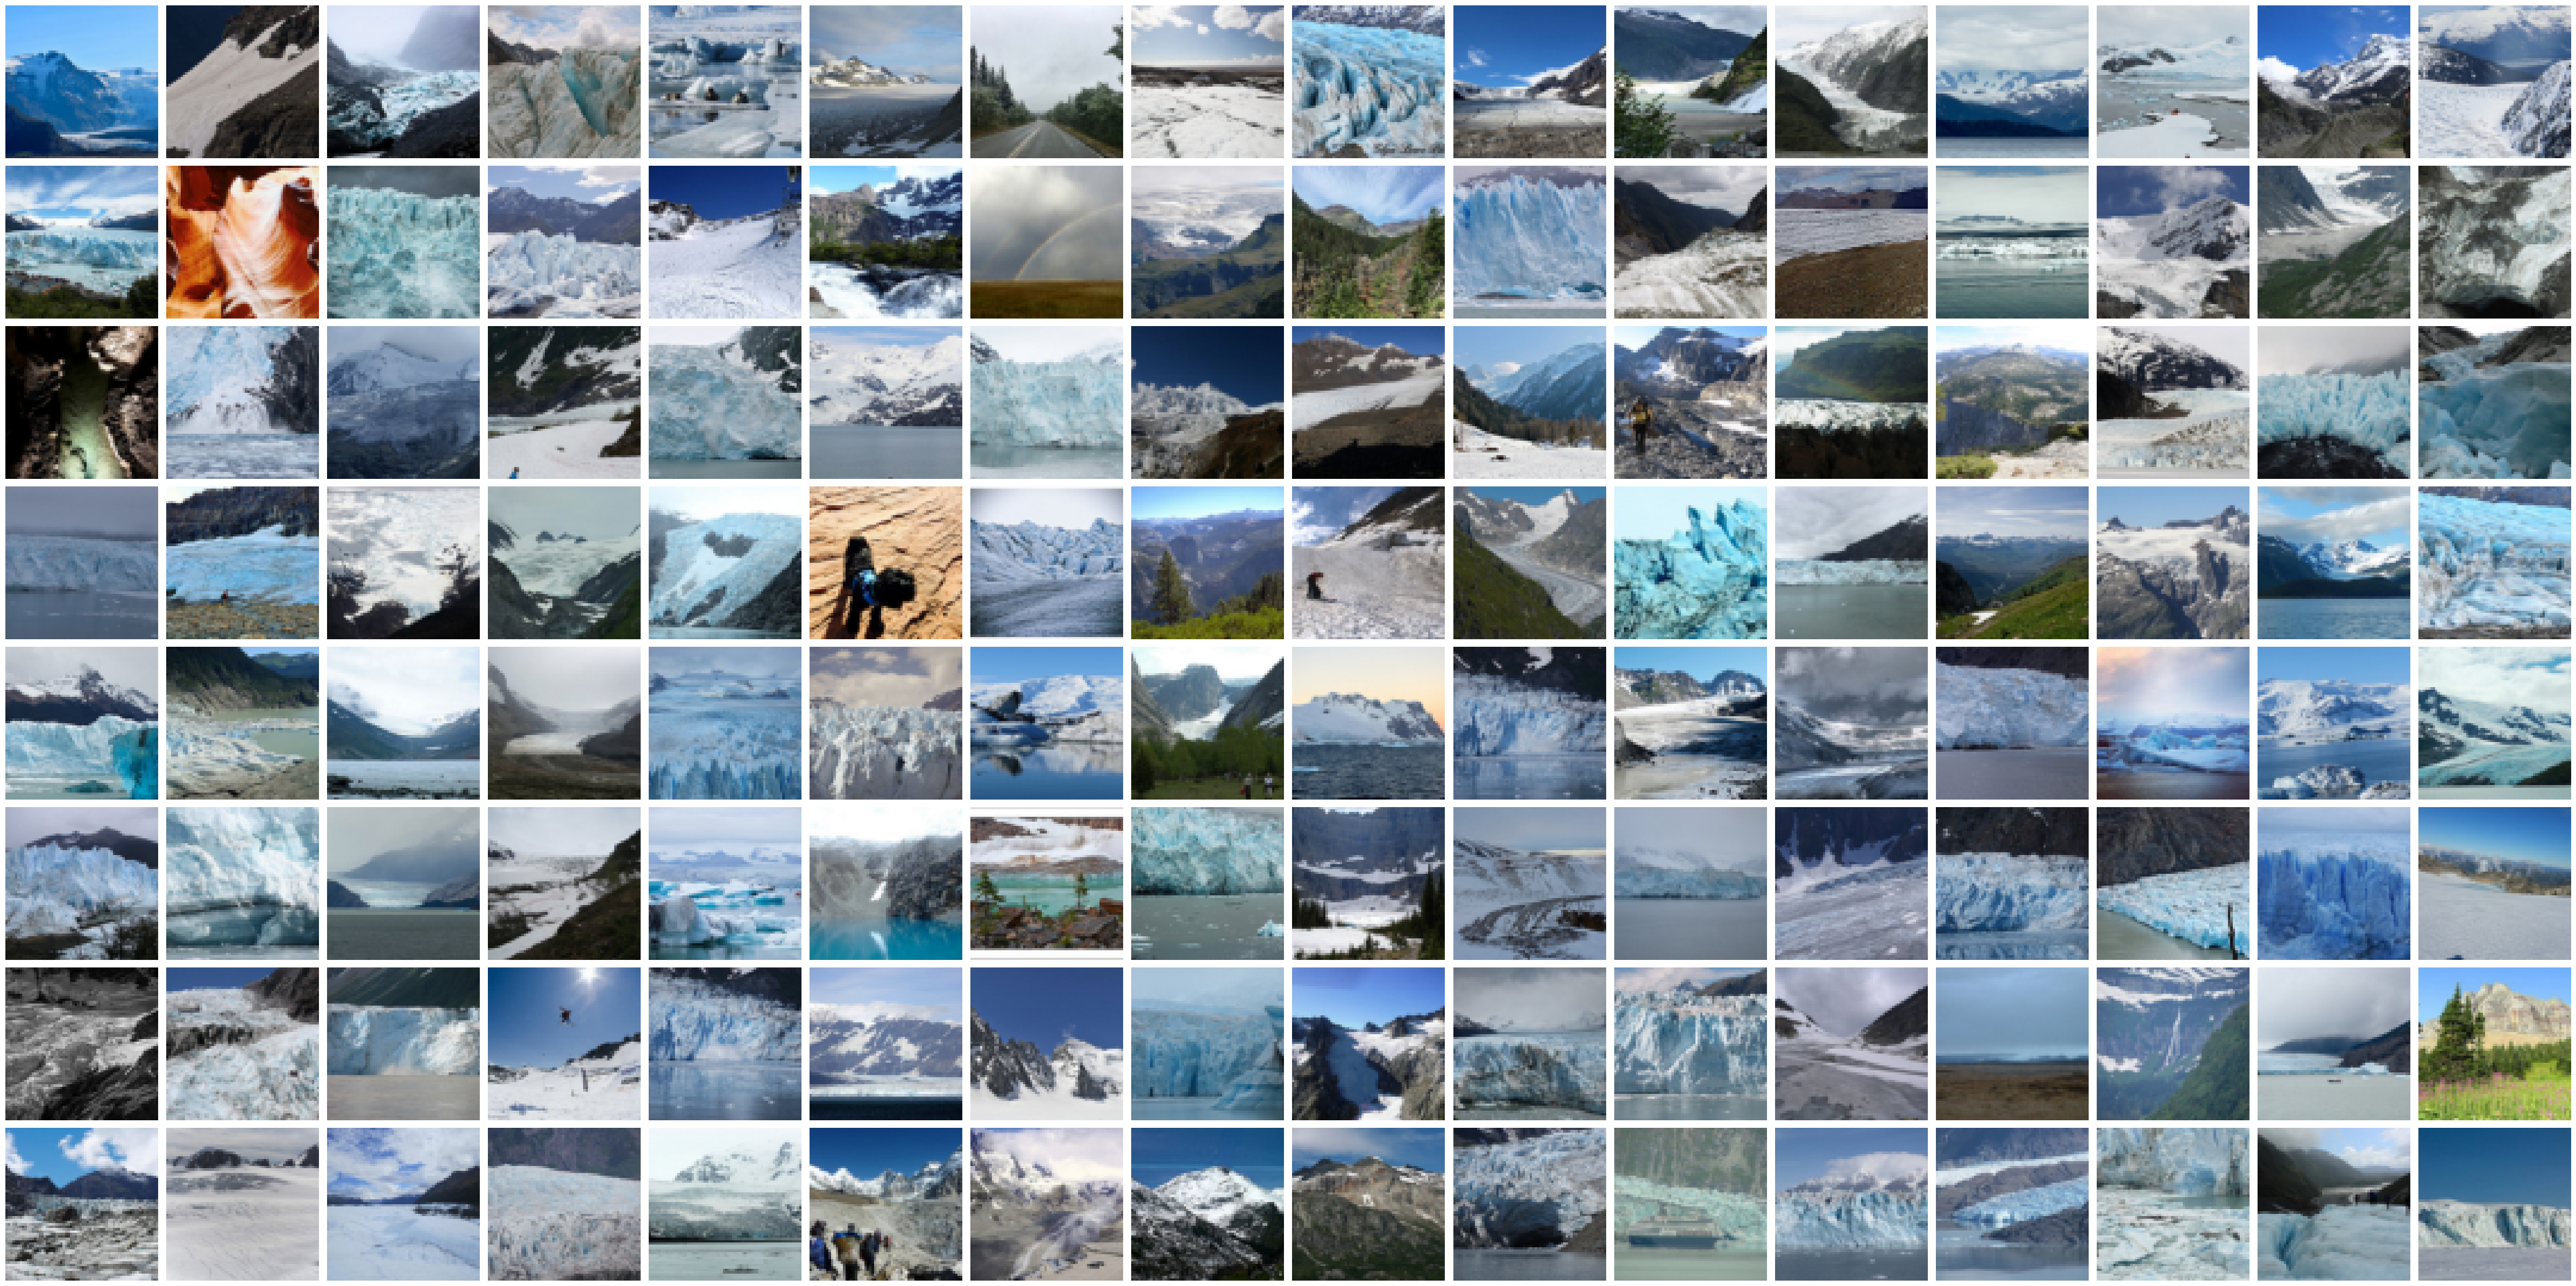

In [12]:
for images in train_loader:
    # print(images)
    show_images(images,16)
    break

In [13]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)


In [14]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [15]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [16]:

z_dim=100
discriminator_lr = 0.0001
generator_lr = 0.0002
ngpu = 2
# generator
generator = Generator(ngpu).to(device)
generator.apply(weights_init)




beta1 = 0.5
g_opt = torch.optim.Adam(generator.parameters(),lr=generator_lr,betas=(beta1, 0.999))


discriminator = Discriminator(ngpu).to(device)
discriminator.apply(weights_init)
d_opt = torch.optim.Adam(discriminator.parameters(),lr=discriminator_lr,betas=(beta1, 0.999))

if (device == 'cuda') and (ngpu > 1):
    print("parallel")
    generator = nn.DataParallel(generator, list(range(ngpu)))
    discriminator = nn.DataParallel(discriminator, list(range(ngpu)))



criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.


parallel


In [17]:
!pip install wandb --quiet

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

os.environ['WANDB_API_KEY'] =   user_secrets.get_secret("WANDB_API_KEY")

!wandb login

wandb: Currently logged in as: sarfarajansari (sarfarajansari-vit-bhopal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


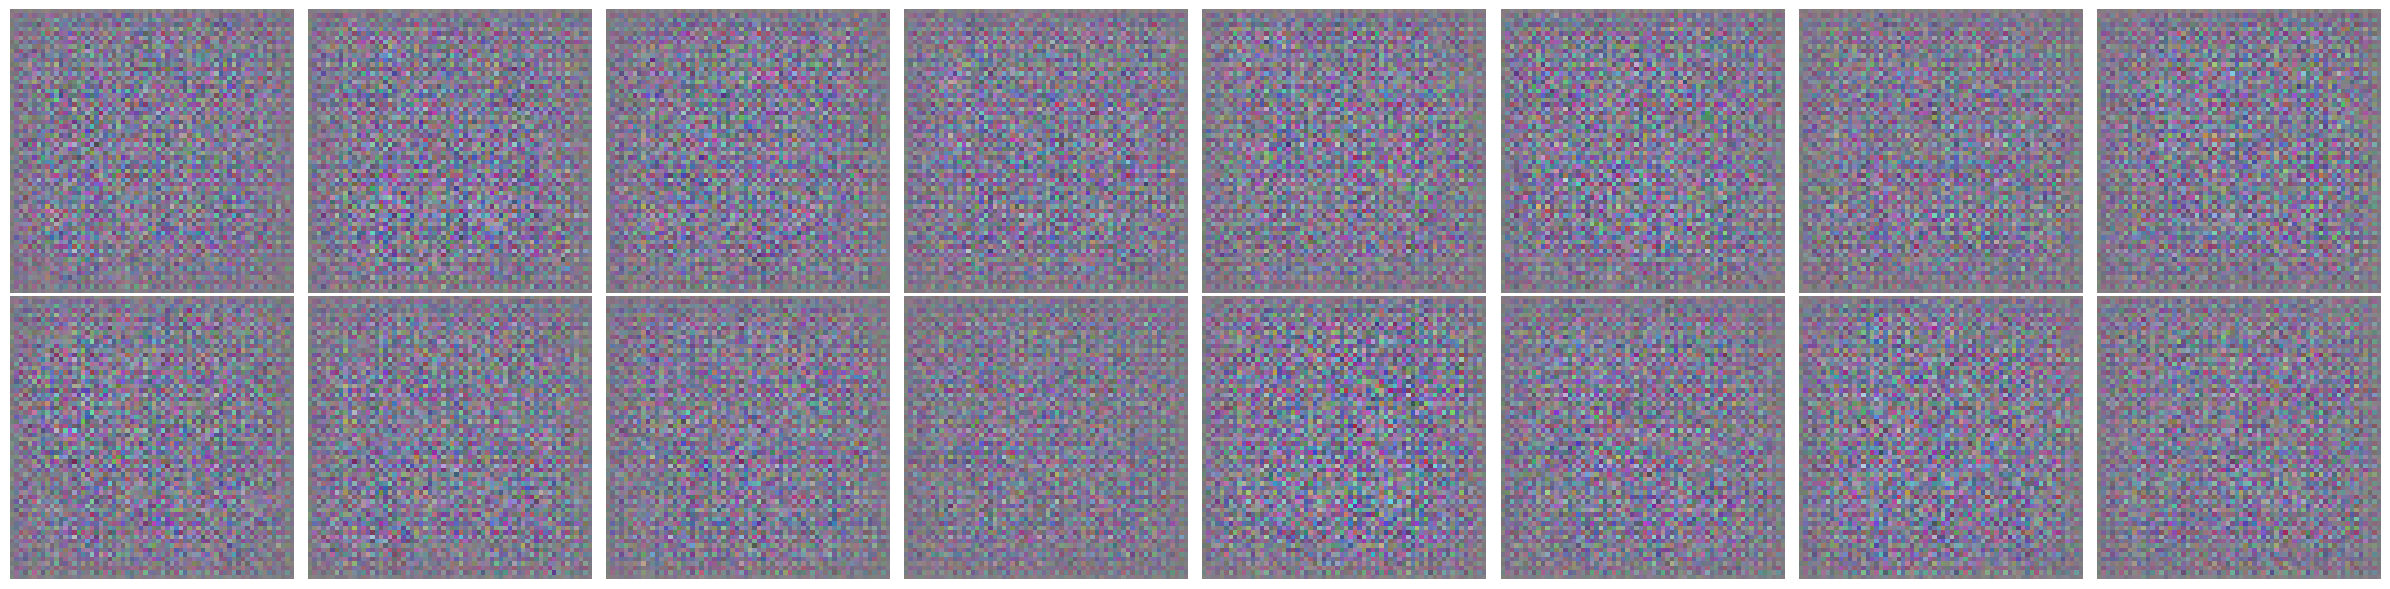

In [18]:
noise = torch.randn(16,z_dim,1,1).to(device)
generated_images = generator(noise)

show_images(generated_images.detach().cpu())

In [19]:
def load_checkpoint(filename='vae_conv_rgb_checkpoint.pth'):
    """
    Loads model and optimizer state from checkpoint if available.
    Returns the epoch to resume from (0 if no checkpoint).
    """
    if os.path.isfile(filename):
        checkpoint = torch.load(filename, map_location=device)

        print(checkpoint.keys())
        generator.load_state_dict(checkpoint['gen_state'])
        g_opt.load_state_dict(checkpoint['gen_opt'])

        discriminator.load_state_dict(checkpoint['dis_state'])
        d_opt.load_state_dict(checkpoint['dis_opt'])
        # start_epoch = checkpoint.get('epoch', 0) + 1
        # print(f"Loaded checkpoint '{filename}' (epoch {checkpoint.get('epoch', 0)})")

        for param_group in g_opt.param_groups:
            param_group['lr'] = generator_lr
        
        for param_group in d_opt.param_groups:
            param_group['lr'] = discriminator_lr
    else:
        print(f"No checkpoint found at '{filename}', starting from scratch.")
        return 0



# load_checkpoint("/kaggle/input/abstract-art-gan/pytorch/v2/1/checkpoint.pth")

In [20]:
num_epochs=400

In [21]:

import wandb
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="sarfarajansari-vit-bhopal",
    # Set the wandb project where this run will be logged.
    project="GAN mountains generation ",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate_d": discriminator_lr,
        "learning_rate_g": generator_lr,
        "architecture": "DCGAN",
        "dataset": "abstract Art",
        "epochs": num_epochs,
        "discriminator": str(discriminator),
        "generator":str(generator)
    },
)


wandb: Currently logged in as: sarfarajansari (sarfarajansari-vit-bhopal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Tracking run with wandb version 0.19.6
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250511_033117-3i8jg1sc
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run polished-dust-6
wandb: ⭐️ View project at https://wandb.ai/sarfarajansari-vit-bhopal/GAN%20mountains%20generation%20
wandb: 🚀 View run at https://wandb.ai/sarfarajansari-vit-bhopal/GAN%20mountains%20generation%20/runs/3i8jg1sc


In [22]:
import torchvision.utils as vutils

def log_generated_images(epoch, num_images=64):
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_images, z_dim, 1, 1, device=device)
        fake_images = generator(noise)
        # Normalize to [0, 1] for logging
        grid = vutils.make_grid(fake_images, normalize=True, nrow=8)
        run.log({"Generated Images": [wandb.Image(grid, caption=f"Epoch {epoch}")]})
    generator.train()

In [23]:
import time

In [24]:
def accuracy(y_pred, y_true, threshold=0.5):
    preds = (y_pred >= threshold).float()  # convert probabilities to 0/1
    correct = (preds == y_true).float()    # compare with ground truth
    acc = correct.mean().item()            # average correctness
    return acc

In [25]:
start_time = time.time()
for epoch in range(num_epochs):
    i=1

    for batch in train_loader:

        # train discriminator with real images
        discriminator.zero_grad()
        discriminator.train()
        real_images = batch.to(device)
        real_size = real_images.size(0)
        label = torch.full((real_size,), real_label, dtype=torch.float, device=device)
        output = discriminator(real_images).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        

        # train discriminator with fake images
        noise = torch.randn(real_size, nz, 1, 1, device=device)
        fake = generator(noise)
        label.fill_(fake_label)
        output = discriminator(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake

        d_opt.step()

        

        generator.train()
        generator.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        g_opt.step()


        progress=epoch + i/len(train_loader)


        run.log({
            "time":time.time() - start_time,
            "progress":progress,
            "generator_loss": errG.item()  ,
            "discriminator_loss": errD.item(),

            "D_x":D_x,
            "D_G_z1":D_G_z1,
            "D_G_z2":D_G_z2
            # "generator_accuracy":acc_g,
            # "discriminator_accuracy":acc_d,
        })
        
        if i % 3==0:
            log_generated_images(progress)

        i+=1
        

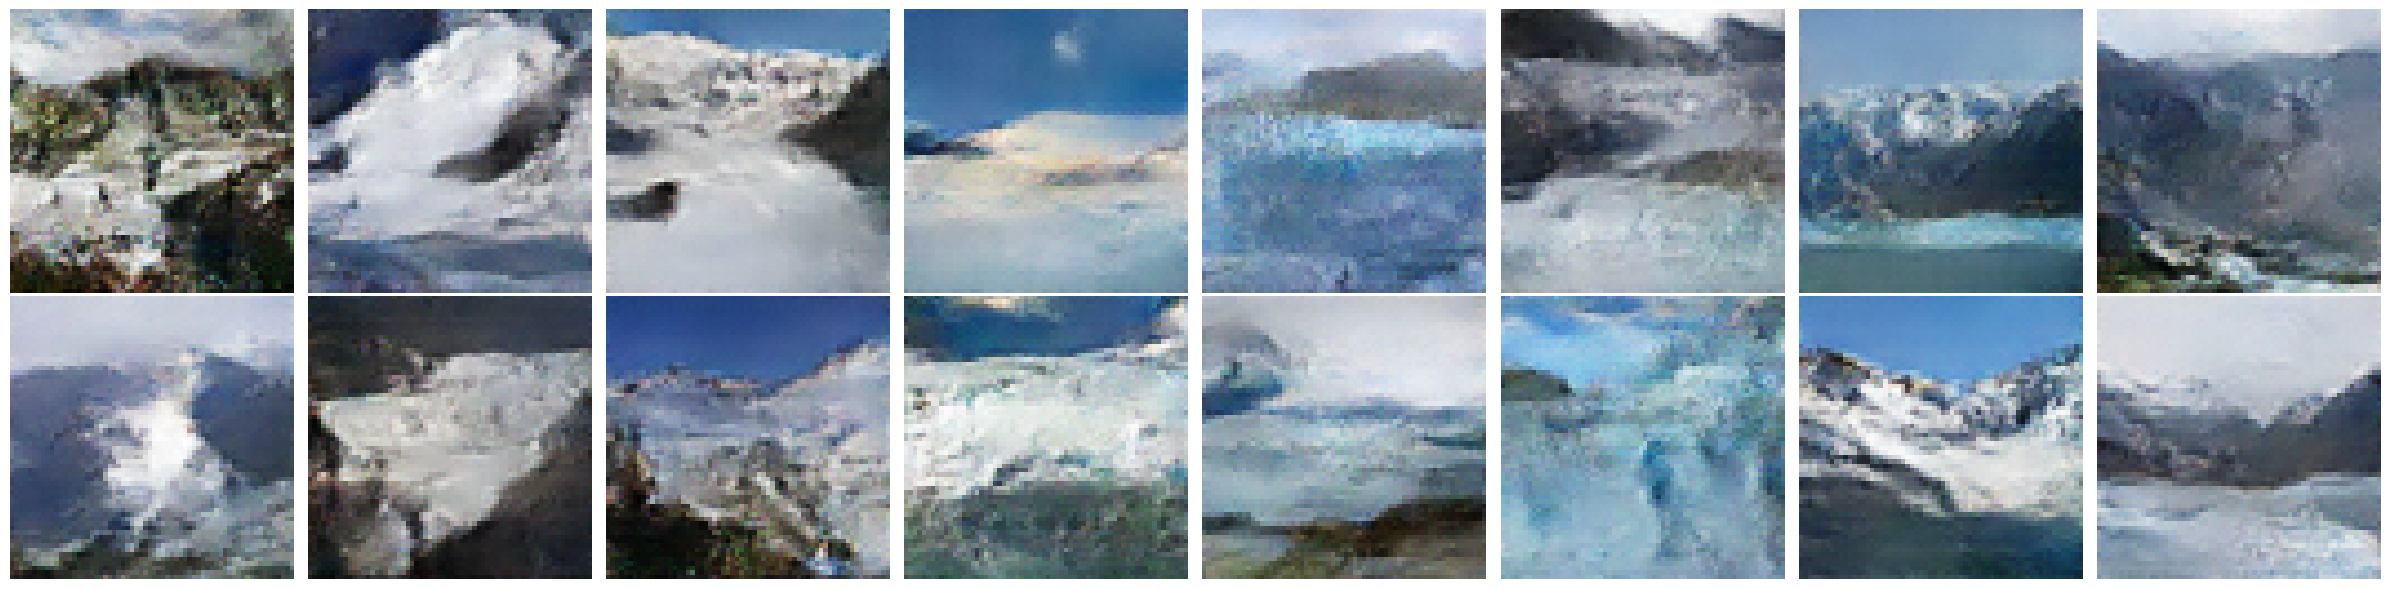

In [26]:
noise = torch.randn(16,z_dim,1,1).to(device)
generated_images = generator(noise)
show_images(generated_images.detach().cpu())

In [27]:
run.finish()

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:             D_G_z1 ▄▅█▃▄▄▇▅▆▂▄▃▃▂▅▄▃▃▃▃▂▆▂▂▁▄▁▁▁▁▁▁▁▁▁▁▁▁▂▁
wandb:             D_G_z2 ▁▂▂▂▆▃▄▂▆▅▇▄█▄▃▄▄▃▂▆▄▃▄▅▄▂▂▄▃▃▂▂▂▂▂▂▂▂▁▁
wandb:                D_x ▇▆▇▄▅▆▁▅▅▅▆▆▃▄▇▆▄▆▆▄▇▇▆▄▇▇██▇█▇█████▇███
wandb: discriminator_loss ▅█▄▅▅▅▇▅▇▇▅▆▆▄▅█▇▄▄▃▄▄▃▃▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁
wandb:     generator_loss █▇▆▂▆▄▃▃▄▄▂▅▄▄▁▃▄▄▄▄▃▃▄▂▄▅▆▆▅▅▅▅▆▆▆▇▇▇▇█
wandb:           progress ▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
wandb:               time ▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇████
wandb: 
wandb: Run summary:
wandb:             D_G_z1 0.02544
wandb:             D_G_z2 0.0103
wandb:                D_x 0.95211
wandb: discriminator_loss 0.07638
wandb:     generator_loss 4.98014
wandb:           progress 400
wandb:               time 1558.3685
wandb: 
wandb: 🚀 View run polished-dust-6 at: https://wandb.ai/sarfarajansari-vit-bhopal/GAN%20mountains%20generation%20/runs/3i8jg1sc
wandb: ⭐️ View pro

In [28]:
torch.save({
    'gen_state': generator.state_dict(),
    'gen_opt': g_opt.state_dict(),
    'dis_state':discriminator.state_dict(),
     'dis_opt': d_opt.state_dict(),
    'wandb_run_id': run.id,          # optional, for W&B integration
    'rng_state': torch.get_rng_state(),  # optional, for exact reproducibility
    
}, 'checkpoint.pth')